In [1]:
import os
import sys
import time
import random
import warnings
import collections
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

In [2]:
# configuration
mco_id = 2
use_cache = False
# use_cache = True
seed = random.randint(0, 100)

print(f'Seed: {seed}')

Seed: 13


In [3]:
query = f"SELECT dtw.* FROM cb.ds_tall_wide dtw JOIN cb.mcos m ON m.id = {mco_id} AND m.ds_batch_id = dtw.ds_batch_id;"
ds_tall_wide = cb_utils.sql_query_to_df(query, use_cache=use_cache)
ds_tall_wide = ds_tall_wide.drop(columns=['created_at'])
ds_tall_wide.transplant_ddos = [0 if r is None else r for r in ds_tall_wide.transplant_ddos]

Pulling query from db


In [4]:
query = f"SELECT v.* FROM cb.ds_vaps v JOIN cb.mcos m on m.id = {mco_id} and m.ds_batch_id = v.ds_batch_id;"
# query = "SELECT * FROM cb.ds_vaps v WHERE v.ds_batch_id = 18;"
vap = cb_utils.sql_query_to_df(query, use_cache=use_cache)

Pulling query from db


In [5]:
query = f"""
    SELECT
        dapu.member_id
      , dapu.period_start              period_end
      , dapu.period_end                period_start
      , dapu.visit_util_attd_pcs * 100 utilized_percentage
      , dapu.visit_per_wk              utilized_hours_per_week
      , dapu.auth_per_wk               total_hours_per_week
      , CASE
            WHEN dapu.visit_util_attd IS NOT NULL AND dapu.visit_util_pcs IS NOT NULL THEN 'S5125, T1019'
            WHEN dapu.visit_util_attd IS NOT NULL                                     THEN 'S5125'
            WHEN dapu.visit_util_pcs IS NOT NULL                                      THEN 'T1019'
            END                        service_codes
    FROM
        cb.members m
        JOIN cb.mcos mco ON m.mco_id = mco.id
        JOIN cb.ds_auth_periods_utilization dapu ON m.id = dapu.member_id AND dapu.ds_batch_id = mco.ds_batch_id
    WHERE m.mco_id = {mco_id};
"""
auth_util = cb_utils.sql_query_to_df(query, use_cache=use_cache)
auth_util.service_codes = auth_util.service_codes.fillna('')
auth_util.fillna(0, inplace=True)

Pulling query from db


In [6]:
# vap.fillna(0, inplace=True)

In [7]:
def pad(i):
    if i < 10:
        return f'0{i}'
    return f'{i}'

In [8]:
hrs_cols = [
    'appropriate_hrs',
    'auth_attd_pcs_hrs',
    'attd_pcs_visit_hrs',
    'pcs_visit_hrs',
    'auth_pcs_hrs',
    'auth_attd_hrs',
    'attd_visit_hrs',
]
ddos_cols = [
    'ed_ddos',
    'ip_ddos',
    'nf_ddos',
#     'snf_ddos',
#     'icf_ddos',
    'hh_ddos',
    'pro_ddos',
    'out_ddos',
    'hcbs_respite_ddos',
    'fall_ddos',   
]

base_columns = hrs_cols + ddos_cols

# V2

In [9]:
ds_tall_wide.head()
ds_tall_wide.fillna(0, inplace=True)

In [10]:
tmelt = ds_tall_wide.melt(id_vars=['member_id', 'period', 'forward_period', 'bom'])

In [11]:
tmelt.head()

,member_id,period,forward_period,bom,variable,value
0,503,0,12,2020-09-01,id,88544.0
1,571,-9,3,2019-12-01,id,88727.0
2,571,-8,4,2020-01-01,id,88728.0
3,571,-7,5,2020-02-01,id,88729.0
4,571,-6,6,2020-03-01,id,88730.0


In [12]:
cost_cols = [c for c in tmelt.variable.unique() if c[-4:] == 'pmpm']
cost_cols

['pmpm',
 'dme_pmpm',
 'care_attdpcs_pmpm',
 'amb_pmpm',
 'ed_pmpm',
 'ip_pmpm',
 'snf_pmpm',
 'icf_pmpm',
 'out_pmpm',
 'pro_pmpm',
 'hh_pmpm']

In [13]:
dx_cols = [c for c in tmelt.variable.unique() if c[-4:] == 'ddos']
dx_cols

['ed_ddos',
 'ip_ddos',
 'nf_ddos',
 'snf_ddos',
 'icf_ddos',
 'hh_ddos',
 'pro_ddos',
 'out_ddos',
 'hcbs_respite_ddos',
 'fall_ddos',
 'alzh_ddos',
 'paralysis_ddos',
 'dementia_ddos',
 'stroke_ddos',
 'psychosis_ddos',
 'tbi_ddos',
 'obese_ddos',
 'oxygen_ddos',
 'hosp_bed_ddos',
 'pressure_ulcer_ddos',
 'paral_mono_ddos',
 'paral_mono_dom_ddos',
 'paral_hemi_ddos',
 'paral_hemi_dom_ddos',
 'paral_para_ddos',
 'paral_quad_ddos',
 'pulmonar_ddos',
 'copd_ddos',
 'chf_ddos',
 'heart_ddos',
 'cancer_ddos',
 'ckd_ddos',
 'esrd_ddos',
 'hyperlipid_ddos',
 'diab_ddos',
 'hypertension_ddos',
 'transplant_ddos',
 'liver_ddos',
 'depression_ddos',
 'drug_ddos',
 'alcohol_ddos',
 'hippfract_ddos']

In [14]:
dx_cols = [
 'alzh_ddos',
 'paralysis_ddos',
 'dementia_ddos',
 'stroke_ddos',
 'psychosis_ddos',
 'tbi_ddos',
 'obese_ddos',
 'oxygen_ddos',
 'hosp_bed_ddos',
 'pressure_ulcer_ddos',
 'paral_mono_ddos',
 'paral_mono_dom_ddos',
 'paral_hemi_ddos',
 'paral_hemi_dom_ddos',
 'paral_para_ddos',
 'paral_quad_ddos',
 'pulmonar_ddos',
 'copd_ddos',
 'chf_ddos',
 'heart_ddos',
 'cancer_ddos',
 'ckd_ddos',
 'esrd_ddos',
 'hyperlipid_ddos',
 'diab_ddos',
 'hypertension_ddos',
 'transplant_ddos',
 'liver_ddos',
 'depression_ddos',
 'drug_ddos',
 'alcohol_ddos',
 'hippfract_ddos' 
]

In [15]:
visit_hrs = ['vhr_01',
 'vhr_02',
 'vhr_03',
 'vhr_04',
 'vhr_05',
 'vhr_06',
 'vhr_07',
 'vhr_08',
 'vhr_09',
 'vhr_10',
 'vhr_11',
 'vhr_12',
 'vhr_13',
 'vhr_14',
 'vhr_15',
 'vhr_16',
 'vhr_17',
 'vhr_18',
 'vhr_19',
 'vhr_20',
 'vhr_21',
 'vhr_22',
 'vhr_23',
 'vhr_24',]
missed_hrs = ['mhr_01',
 'mhr_02',
 'mhr_03',
 'mhr_04',
 'mhr_05',
 'mhr_06',
 'mhr_07',
 'mhr_08',
 'mhr_09',
 'mhr_10',
 'mhr_11',
 'mhr_12',
 'mhr_13',
 'mhr_14',
 'mhr_15',
 'mhr_16',
 'mhr_17',
 'mhr_18',
 'mhr_19',
 'mhr_20',
 'mhr_21',
 'mhr_22',
 'mhr_23',
 'mhr_24',]

In [16]:
tmelt = tmelt.rename(columns={'bom': 'Month'})
# sns blows up silently and starts diaspearing shit if the x axis is date type. brutal.
tmelt.Month = tmelt.Month.astype(str)

In [ ]:
def graph_member(member_id, save=True):
    # I expect to see SNS RuntimeWarnings in this block
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        warnings.simplefilter("ignore", category=UserWarning)
        if not save:
            print('Graphing: ', member_id)
        #     member_id = 2788
        #     print(f'Graphing {i+1}/{n}')
        member = ds_tall_wide.query('member_id == @member_id')
        [age_yr, grp, grp_end, grp_2_days, grp_3_days] = member[['age_yr', 'grp_yr', 'grp_end_yr', 'grp_2_days_yr', 'grp_3_days_yr']].values[0]
        title = f'MemberID: ({member_id}) Age:({age_yr}) Group:({grp}), @end:({grp_end}). Group Days two:({grp_2_days}), three:({grp_3_days})'

        if  member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum().sum() > 0:
            care_cls_pmpm, care_aclf_pmpm, care_alfgc_pmpm, care_adult_day_pmpm = member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum()
            title += f'\nCare PMPMs CLS(${care_cls_pmpm}), ACLF(${care_aclf_pmpm}), ALFGC(${care_alfgc_pmpm}), Adult Day(${care_adult_day_pmpm})'

        mems = tmelt.query("member_id == @member_id")
        lines_df = mems.query("variable in @hrs_cols")

        lines_df = lines_df.rename(columns={"value": "Hours", "variable": 'Type of Hours'})
        lines_df['Type of Hours'] = lines_df['Type of Hours'].map({
            'appropriate_hrs': 'Adjusted Hrs',
            'auth_attd_pcs_hrs': 'Auth Hrs',
            'attd_pcs_visit_hrs': 'Visit Hrs',
            'pcs_visit_hrs': 'PCS Visit',
            'auth_pcs_hrs': 'PCS Auth',
            'auth_attd_hrs': 'Attd Auth',
            'attd_visit_hrs': 'Attd Visit',
        })

        lines_df.Hours = lines_df.Hours.astype(int)
        bars_df = mems.query("variable not in ['auth_attd_pcs_hrs', 'attd_pcs_visit_hrs']")
        bars_df = bars_df.rename(columns={"value": "Days of Service", 'variable': 'Event'})
        bars_df.Event = bars_df.Event.map({
            'ed_ddos': 'ED',
            'ip_ddos': 'IP',
            'nf_ddos': 'NF',
        #         'snf_ddos': 'SNF',
        #         'icf_ddos': 'ICF',
            'hh_ddos': 'HH',
            'pro_ddos': 'Pro',
            'out_ddos': 'Out',
            'hcbs_respite_ddos': 'HCBS Respite',
            'fall_ddos': 'Falls'
        })

        bar_palette = {
            'IP': "#E8000B",
            'ED': "#F14CC1",
            'NF': "#FF7C00",
            'HH': "#FFC400",
            'Pro': "#A3A3A3",
            'Out': "#12711C",
            'HCBS Respite': "#0173B2",
            'Falls': '#000000'
        }
        bar_hue_order = ['IP', 'ED', 'NF', 'HH', 'Pro', 'Out', 'HCBS Respite', 'Falls']

        line_palette = {
            'Adjusted Hrs': "#1AC938",
            'Auth Hrs': "#001C7F",
            'Visit Hrs': "#D55E00",
            'PCS Visit': "#FFB482",
            'PCS Auth': "#A1C9F4",
            'Attd Visit': "#FFB482",
            'Attd Auth': "#A1C9F4",
        }
        line_dash = {
            'Adjusted Hrs': (2, 2),
            'Auth Hrs': "",
            'Visit Hrs': "",
            'PCS Visit': (8, 2),
            'PCS Auth': (8, 2),
            'Attd Visit': (2,2),
            'Attd Auth': (2,2),   
        }

        line_style_order = ['Adjusted Hrs', 'Auth Hrs', 'Visit Hrs', 'PCS Visit', 'PCS Auth', 'Attd Visit', 'Attd Auth' ]



        #     fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 35))

        fig = plt.figure(tight_layout=True, figsize=(18, 24))
        gs = gridspec.GridSpec(4, 3)

        #####
        # Hrs
        #####
        ax = fig.add_subplot(gs[0, :])
        #     ax = axes[0]
        x = 'Month'
        ax = sns.lineplot(ax=ax, x=x, y='Hours', hue='Type of Hours', style='Type of Hours', palette=line_palette, dashes=line_dash, style_order=line_style_order, data=lines_df.loc[lines_df['Type of Hours'] != 'Adjusted Hrs'])
        ax = sns.lineplot(ax=ax, x=x, y='Hours', legend=False, hue='Type of Hours', style='Type of Hours', palette=line_palette, dashes=line_dash, style_order=line_style_order, data=lines_df.loc[lines_df['Type of Hours'] == 'Adjusted Hrs'], linewidth=4)
        ax.legend(loc='upper left')

        ax.set(title=title)
        # ax.set(ylim=(0, 300))

        #####
        # DDOS Spend Type
        #####
        ax2 = ax.twinx()
        pal = sns.color_palette("Set3", 9)
        ax2 = sns.barplot(x=x, y='Days of Service', hue='Event', hue_order=bar_hue_order, palette=bar_palette, ax=ax2, data=bars_df)
        ax2.legend(loc='upper right')

        ax2.set(ylim=(0, 20))
        ax2.grid(False)




        #####
        # DX DDOS
        #####

        #     ax = axes[1]
        ax = fig.add_subplot(gs[1, :])
        ax.set(title="DX Distinct Days of Service")
        grid = member[['bom'] + dx_cols].set_index('bom').transpose().sort_index()
        grid.index = grid.index.map({
             'alzh_ddos': 'Alzheimers',
             'paralysis_ddos': 'Paralysis',
             'dementia_ddos': 'Dementia',
             'stroke_ddos': 'Stroke',
             'psychosis_ddos': 'Psychosis',
             'tbi_ddos': 'Tbi',
             'obese_ddos': 'Obese',
             'oxygen_ddos': 'Oxygen',
             'hosp_bed_ddos': 'Hosp Bed',
             'pressure_ulcer_ddos': 'Pressure Ulcer',
             'paral_mono_ddos': 'Paral Mono',
             'paral_mono_dom_ddos': 'Paral Mono Dom',
             'paral_hemi_ddos': 'Paral Hemi',
             'paral_hemi_dom_ddos': 'Paral Hemi Dom',
             'paral_para_ddos': 'Paral Para',
             'paral_quad_ddos': 'Paral Quad',

             'pulmonar_ddos': 'Pulmonary',
             'copd_ddos': 'COPD',
             'chf_ddos': 'CHF',
             'heart_ddos': 'Heart',
             'cancer_ddos': 'Cancer',
             'ckd_ddos': 'CKD',
             'esrd_ddos': 'ESRD',
             'hyperlipid_ddos': 'Hyperlipid',
             'diab_ddos': 'Diabetes',
             'hypertension_ddos': 'Hypertension',
             'transplant_ddos': 'Transplant',
             'liver_ddos': 'Liver',
             'depression_ddos': 'Depression',
             'drug_ddos': 'Drug',
             'alcohol_ddos': 'Alcohol',
             'hippfract_ddos': 'Hip Fracture' 
        })
        grid.iloc[grid == 0] = np.nan
        sns.heatmap(grid, ax=ax,  yticklabels=True, xticklabels=True,robust=True, annot=True, linewidths=.5, cmap="YlOrRd", cbar=False, vmin=1)
        ax.set_xlabel("Month")

        #####
        # PMPMs
        #####
        pmpms = mems.query('variable in @cost_cols')

        pmpms = pmpms.rename(columns={"value": "Dollars"})
        pmpms['variable'] = pmpms['variable'].map({
             'pmpm': 'TC PMPM',
             'dme_pmpm': 'DME',
             'care_attdpcs_pmpm': 'Care ATTDPCS',
             'amb_pmpm': 'AMB',
             'ed_pmpm': 'ED',
             'ip_pmpm': 'IP',
             'snf_pmpm': 'SNF',
             'icf_pmpm': 'ICF',
             'out_pmpm': 'OUT',
             'pro_pmpm': 'PRO',
             'hh_pmpm': 'HH'
        })

        pmpm_palette = {
           'TC PMPM': "#0173B2",
           'DME': "#12711C",
           'Care ATTDPCS': "#8172B3",
           'AMB': '#000000',
           'ED': "#F14CC1",
           'IP': "#E8000B",
           'SNF': "#FF7C00",
           'ICF': "#FF7C00",
           'OUT': "#12711C",
           'PRO': "#A3A3A3",
           'HH': "#FFC400",
        }
        pmpm_order = [
            'TC PMPM',
            'IP',
            'ED',
            'AMB',
            'SNF',
            'ICF',
            'DME',
            'Care ATTDPCS',
            'OUT',
            'PRO',
            'HH'
        ]

        ax = fig.add_subplot(gs[3, :])
        #     ax = axes[2]
        ax = sns.lineplot(ax=ax, x=x, y='Dollars', hue='variable', palette=pmpm_palette, hue_order=pmpm_order, data=pmpms.query('variable != "TC PMPM"'))
        ax.set(title="PMPMs")
        ax.set_ylabel("Cost by Category")
        ax.legend(loc='upper right')

        ax2 = ax.twinx()
        ax2 = sns.lineplot(ax=ax2, x=x, y='Dollars', linewidth=4, alpha=.7, hue='variable', palette=pmpm_palette, hue_order=pmpm_order, legend=False, data=pmpms.query('variable == "TC PMPM"'))
        ax2.set_ylabel("Total Cost")
        ax2.grid(False)

        #####
        # Schedule
        #####
        grp = 'all'
        mem = vap.query('member_id == @member_id and procedure_code == @grp')


        mem = mem.replace(0, np.nan)

        visit_grid = mem[['good_day'] + visit_hrs].set_index('good_day')
        visit_grid = visit_grid.sort_index().transpose()
        visit_grid.index = visit_grid.index.map(lambda x: x[4:])

        missed_grid = mem[['good_day'] + missed_hrs].set_index('good_day')
        missed_grid = missed_grid.sort_index().transpose()
        missed_grid.index = missed_grid.index.map(lambda x: x[4:])


        ax = fig.add_subplot(gs[2, 0])
        #     ax = axes[3]
        ax = sns.heatmap(visit_grid, ax=ax, robust=True, annot=True, linewidths=.5, cmap="YlOrRd", vmin=1, cbar=False, fmt='g') #  ,
        ax.set(title=f'Visit Minutes')
        ax.set_xlabel('Day')
        ax.set_ylabel('Hour')

        #     ax = axes[4]
        ax = fig.add_subplot(gs[2, 1])
        ax = sns.heatmap(missed_grid, ax=ax, robust=True, annot=True, linewidths=.5, cmap="YlOrRd", vmin=1, cbar=False, fmt='g') #  ,
        ax.set(title=f'Missed Minutes')
        ax.set_xlabel('Day')
        ax.set_ylabel('Hour')
        
        
        # auths
        ax = fig.add_subplot(gs[2, 2])
        m = auth_util.query('member_id==@member_id')
        m = m.assign(y=m.service_codes + ': ' + m.period_start.astype(str) + ' to ' + m.period_end.astype(str) +  ' ' + m.utilized_percentage.astype(str))

        sns.set_color_codes("pastel")
        sns.barplot(x='total_hours_per_week', y='y', data=m, color="b", ax=ax, label="Total")

        sns.set_color_codes("muted")
        sns.barplot(x='utilized_hours_per_week', y='y', data=m, color="b", ax=ax, label="Utilized")

        
        for i, (up, patch) in enumerate(zip(m.y, ax.patches)):
#         for i, (up, patch) in enumerate(zip(m.utilized_percentage.fillna('0'), ax.patches)):
            if m.total_hours_per_week.values[i] > 0:
                height = patch.get_height()
                ax.text(
                    height, # bar index (x coordinate of text)
                    i, # y coordinate of text
                    '{}%'.format(up),  # y label
                    ha='left', 
                    va='center', 
                    fontweight='bold', 
                    size=12)

        sns.despine(left=True, bottom=True)

        ax.legend(ncol=2, loc="upper right", frameon=True)
        ax.set_xlabel('Hours Per Week')
        ax.set_ylabel(None)
        ax.set_yticklabels([])
        ax.set(title='Authorizations')
        


    #     plt.tight_layout()
    if save:
        plt.savefig(f'outputs/anthem_20201012/{member_id}_ds.png')
    #         plt.savefig(f'outputs/{member_id}_w_ds.png', bbox_inches = 'tight', pad_inches = 0)
        plt.close(fig)


for i in range(10):
    graph_member(random.choice(ds_tall_wide.member_id.unique()), save=False)
# graph_member(2915, save=False)

In [ ]:
auth_util.query('member_id == 3009')

In [ ]:
ds_tall_wide.loc[ds_tall_wide.member_id == 22169].head()

In [ ]:
ds_tall_wide.dtypes

In [ ]:

# graph_member(random.choice(ds_tall_wide.member_id.unique()), save=False)
# graph_member(2788, save=True)
# graph_member(270, save=True)
# graph_member(988, save=True)

In [ ]:
# run_save_all_members = True
# if run_save_all_members:
#     with Pool() as pool:
#         pool.map(graph_member, sorted(ds_tall_wide.member_id.unique()))
for member_id in tqdm(sorted(ds_tall_wide.member_id.unique())):
    graph_member(member_id)

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

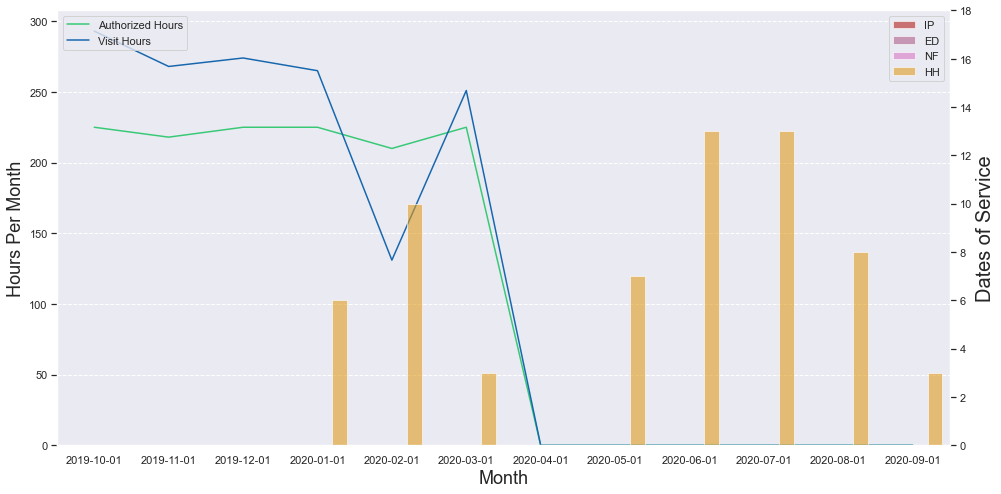

In [17]:
def graph_member_small(member_id, save=True):
#     print(f'Graphing {i+1}/{n}')
    member = ds_tall_wide.query('member_id == @member_id')
    [age_yr, grp, grp_end, grp_2_days, grp_3_days] = member[['age_yr', 'grp_yr', 'grp_end_yr', 'grp_2_days_yr', 'grp_3_days_yr']].values[0]
    title = f'MemberID: ({member_id}) Age:({age_yr}) Group:({grp}), @end:({grp_end}). Group Days two:({grp_2_days}), three:({grp_3_days})'

    if  member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum().sum() > 0:
        care_cls_pmpm, care_aclf_pmpm, care_alfgc_pmpm, care_adult_day_pmpm = member[['care_cls_pmpm_yr', 'care_aclf_pmpm_yr', 'care_alfgc_pmpm_yr', 'care_adult_day_pmpm_yr']].sum()
        title += f'\nCare PMPMs CLS(${care_cls_pmpm}), ACLF(${care_aclf_pmpm}), ALFGC(${care_alfgc_pmpm}), Adult Day(${care_adult_day_pmpm})'

    h_cols = [
#         'appropriate_hrs',
        'auth_attd_pcs_hrs',
        'attd_pcs_visit_hrs',
#         'pcs_visit_hrs',
#         'auth_pcs_hrs',
#         'auth_attd_hrs',
#         'attd_visit_hrs',
    ]
    
    mems = tmelt.query("member_id == @member_id")
    lines_df = mems.query("variable in @h_cols")
    auth = 'Authorized Hours'
    visit = 'Visit Hours'

    lines_df = lines_df.rename(columns={"value": "Hours", "variable": 'Type of Hours'})
    lines_df['Type of Hours'] = lines_df['Type of Hours'].map({
        'appropriate_hrs': 'Appr Hrs',
        'auth_attd_pcs_hrs': auth,
        'attd_pcs_visit_hrs': visit,
        'pcs_visit_hrs': 'PCS Visit',
        'auth_pcs_hrs': 'PCS Auth',
        'auth_attd_hrs': 'Attd Auth',
        'attd_visit_hrs': 'Attd Visit',
    })


    excluded_bars = ['auth_attd_pcs_hrs', 'attd_pcs_visit_hrs', 'pro_ddos', 'out_ddos', 'falls_ddos', 'hcbs_respite_ddos']
    bars_df = mems.query("variable not in @excluded_bars")
    bars_df = bars_df.rename(columns={"value": "Days of Service", 'variable': 'Event'})
    bars_df.Event = bars_df.Event.map({
        'ed_ddos': 'ED',
        'ip_ddos': 'IP',
        'nf_ddos': 'NF',
    #         'snf_ddos': 'SNF',
    #         'icf_ddos': 'ICF',
        'hh_ddos': 'HH',
        'pro_ddos': 'Pro',
        'out_ddos': 'Out',
        'hcbs_respite_ddos': 'HCBS Respite',
        'fall_ddos': 'Falls'
    })


    bar_palette = {
        'IP': "#CC0606",
        'ED': "#BC5090",
        'NF': "#EB67D0",
        'HH': "#FFA600",
#         'HCBS Respite': "#0173B2",
#         'Pro': "#A3A3A3",
#         'Out': "#12711C",
#         'Falls': '#000000'
    }
    bar_hue_order = ['IP',
                     'ED',
                     'NF',
                     'HH',
#                      'HCBS Respite',
#                      'Pro',
#                      'Out',
#                      'Falls'
                    ]

    line_palette = {
#         'Appr Hrs': "#1AC938",
        auth: "#38C976",
        visit: "#1767AE",
#         'PCS Visit': "#FFB482",
#         'PCS Auth': "#A1C9F4",
#         'Attd Visit': "#FFB482",
#         'Attd Auth': "#A1C9F4",
    }
    line_dash = {
#         'Appr Hrs': "",
        auth: "",
        visit: "",
#         'PCS Visit': (8, 2),
#         'PCS Auth': (8, 2),
#         'Attd Visit': (2,2),
#         'Attd Auth': (2,2),   
    }
    
    line_style_order = [
#         'Appr Hrs',
        auth,
        visit,
#         'PCS Visit',
#         'PCS Auth',
#         'Attd Visit',
#         'Attd Auth'
    ]


    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    
    #####
    # Hrs
    #####
    ax = axes
    x = 'Month'
    ax = sns.lineplot(ax=ax, x=x, y='Hours', hue='Type of Hours', style='Type of Hours', palette=line_palette, dashes=line_dash, style_order=line_style_order, data=lines_df)
    ax.set_ylabel('Hours Per Month')
    ax.legend(loc='upper left')
    ax.grid(False)
    ax.grid(axis='y', linestyle='--')
    ax.set_ylim(bottom=0)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)


#     ax.set(title=title)
    
    #####
    # DDOS Spend Type
    #####
    ax2 = ax.twinx()
    pal = sns.color_palette("Set3", 9)
    ax2 = sns.barplot(x=x, y='Days of Service', hue='Event', alpha=.6, hue_order=bar_hue_order, palette=bar_palette, ax=ax2, data=bars_df)
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Dates of Service')

    ax2.set(ylim=(0, 18))
    ax2.grid(False)
    
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    if save:
        plt.savefig(f'outputs/{member_id}_small.png', bbox_inches = 'tight', pad_inches = 0)
#     plt.savefig('small.png')
        plt.close(fig)
    
graph_member_small(random.choice(ds_tall_wide.member_id.unique()), save=False)

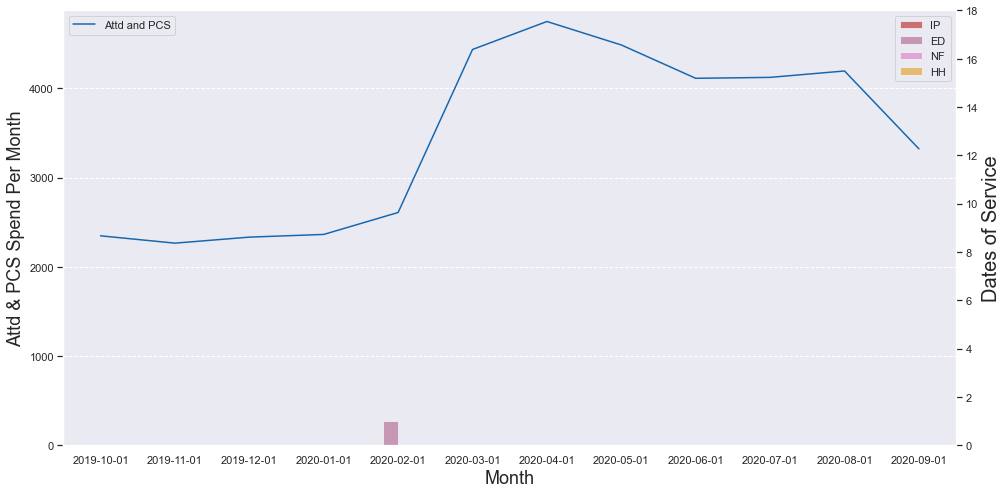

In [30]:
def graph_member_small_two(member_id, save=True):
    member = ds_tall_wide.query('member_id == @member_id')

    mems = tmelt.query("member_id == @member_id")
    
    lines_df = mems.query("variable=='care_attdpcs_pmpm'")
    care_attdpcs_pmpm = 'Attd and PCS'
    lines_df = lines_df.rename(columns={"value": "PMPM", "variable": 'Service Type'})
    lines_df['Service Type'] = lines_df['Service Type'].map({
        'care_attdpcs_pmpm': care_attdpcs_pmpm 
    })
    line_palette = { care_attdpcs_pmpm: "#1767AE" }


    excluded_bars = ['auth_attd_pcs_hrs', 'attd_pcs_visit_hrs', 'pro_ddos', 'out_ddos', 'falls_ddos', 'hcbs_respite_ddos']
    bars_df = mems.query("variable not in @excluded_bars")
    bars_df = bars_df.rename(columns={"value": "Days of Service", 'variable': 'Event'})
    bars_df.Event = bars_df.Event.map({
        'ed_ddos': 'ED',
        'ip_ddos': 'IP',
        'nf_ddos': 'NF',
        'hh_ddos': 'HH',
        'pro_ddos': 'Pro',
        'out_ddos': 'Out',
        'hcbs_respite_ddos': 'HCBS Respite',
        'fall_ddos': 'Falls'
    })


    bar_palette = {
        'IP': "#CC0606",
        'ED': "#BC5090",
        'NF': "#EB67D0",
        'HH': "#FFA600",
    }
    bar_hue_order = ['IP',
                     'ED',
                     'NF',
                     'HH',
                    ]



    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    
    #####
    # Hrs
    #####
    ax = axes
    x = 'Month'
    ax = sns.lineplot(ax=ax, x=x, y='PMPM', hue='Service Type', palette=line_palette, data=lines_df)
    ax.set_ylabel('Attd & PCS Spend Per Month')
    ax.legend(loc='upper left')
    ax.grid(False)
    ax.grid(axis='y', linestyle='--')
    ax.set_ylim(bottom=0)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)


#     ax.set(title=title)
    
    #####
    # DDOS Spend Type
    #####
    ax2 = ax.twinx()
    pal = sns.color_palette("Set3", 9)
    ax2 = sns.barplot(x=x, y='Days of Service', hue='Event', alpha=.6, hue_order=bar_hue_order, palette=bar_palette, ax=ax2, data=bars_df)
    ax2.legend(loc='upper right')
    ax2.set_ylabel('Dates of Service')

    ax2.set(ylim=(0, 18))
    ax2.grid(False)
    
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    if save:
        plt.savefig(f'outputs/{member_id}_small.png', bbox_inches = 'tight', pad_inches = 0)
#     plt.savefig('small.png')
        plt.close(fig)
    
graph_member_small_two(random.choice(ds_tall_wide.member_id.unique()), save=False)

In [ ]:
smalls = [21013
, 21403
, 22162
, 22257
, 22580
, 22665
, 23052
, 23144
, 23107
, 27654
, 27836
]

In [ ]:
for member_id in tqdm(smalls):
# for member_id in tqdm(sorted(ds_tall_wide.member_id.unique())):
    graph_member_small(member_id)

In [ ]:
auth_util.head()

In [ ]:
member_id = random.choice(auth_util.member_id.unique())
m = auth_util.query('member_id==@member_id')
m = m.assign(y=m.service_codes.fillna('N/A') + ': ' + m.period_start.astype(str) + ' - ' + m.period_end.astype(str))

# Initialize the matplotlib figure
f, ax = plt.subplots()
# f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
sns.barplot(x='total_hours_per_week', y='y', data=m, color="b", ax=ax, label="Total")

sns.set_color_codes("muted")
sns.barplot(x='utilized_hours_per_week', y='y', data=m, color="b", ax=ax, label="Utilized")

for i, (up, patch) in enumerate(zip(m.utilized_percentage.fillna('0'), ax.patches)):
    height = patch.get_height()
    ax.text(
        height, # bar index (x coordinate of text)
        i, # y coordinate of text
        '{}%'.format(up),  # y label
        ha='left', 
        va='center', 
        fontweight='bold', 
        size=14)

sns.despine(left=True, bottom=True)

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set_xlabel('Hours Per Week')
ax.set_ylabel('Authorization')

In [ ]:
for nr, p in enumerate(ax.patches):
    print(p.get_width())